<a href="https://colab.research.google.com/github/yashvi000/ML-Tutorial/blob/main/Regression_%5BSeoul_bike_dataset%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seoul Bike Sharing Demand dataset - Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Seasons", "Holiday"], axis=1)   # axis=1 means columns
cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df.columns = cols

In [3]:
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 13]    # Taking only the 13th hour
df = df.drop("hour", axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
13,451,2.4,25,1.6,2000,-15.6,1.16,0.0,0.0,1
37,606,6.0,36,1.8,1780,-7.9,1.12,0.0,0.0,1
61,495,6.8,81,1.9,390,3.7,0.60,0.0,0.0,1
85,391,0.0,30,5.4,1938,-15.5,1.17,0.0,0.0,1
109,325,-1.6,27,0.0,1955,-18.2,0.00,0.0,0.0,1


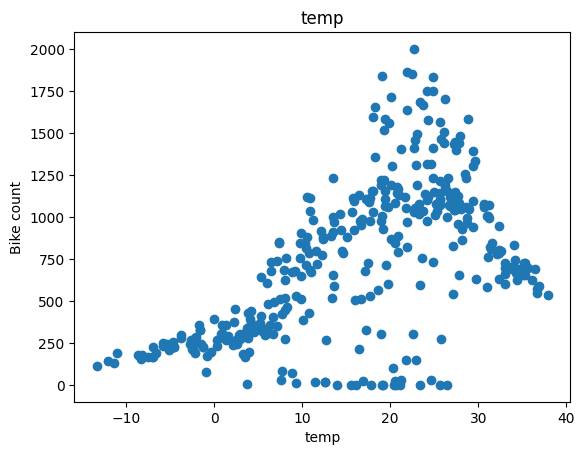

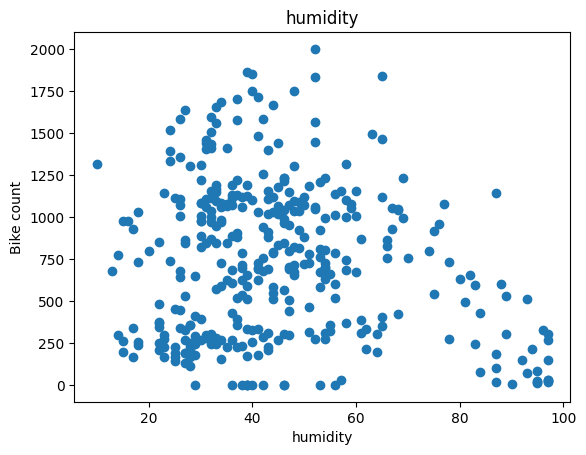

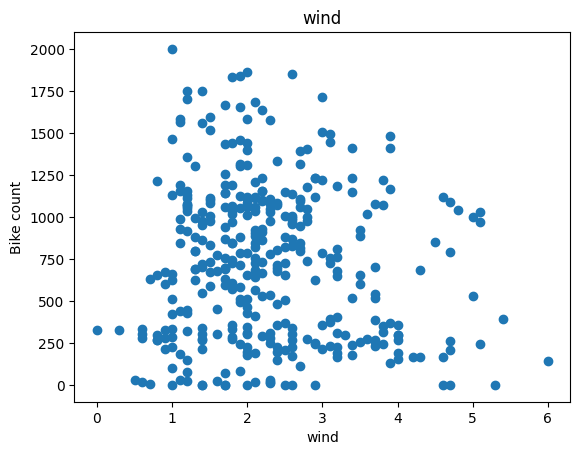

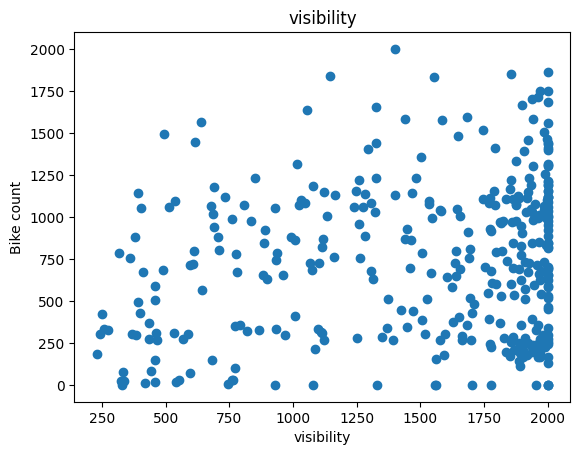

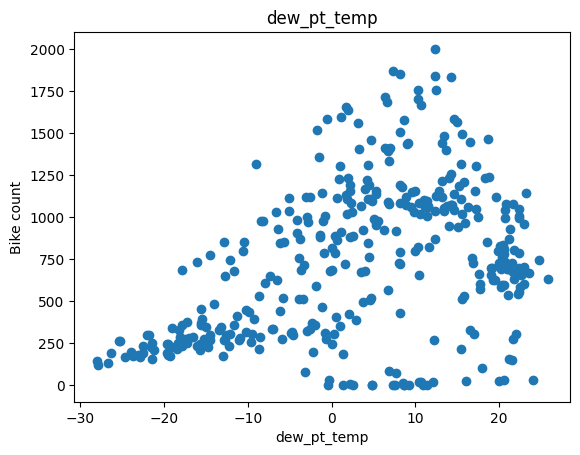

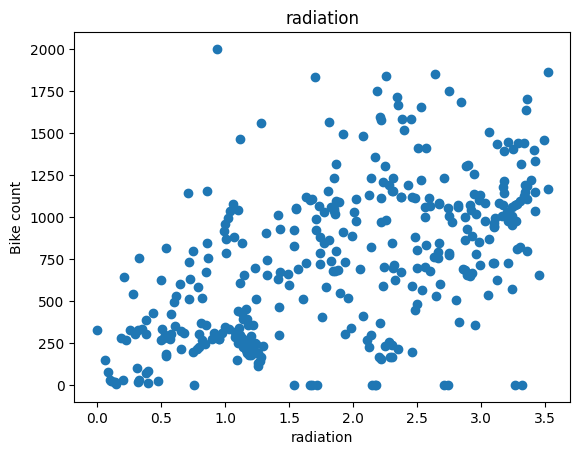

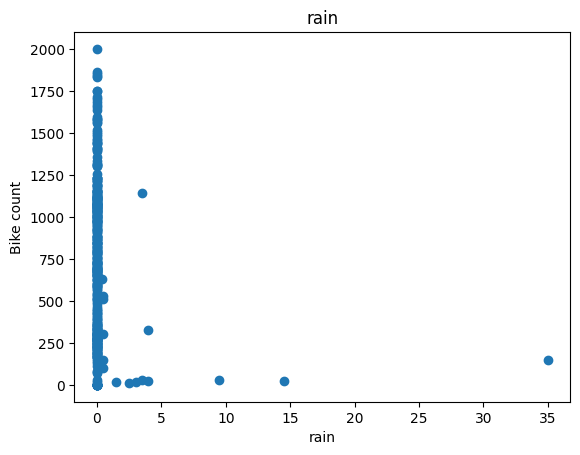

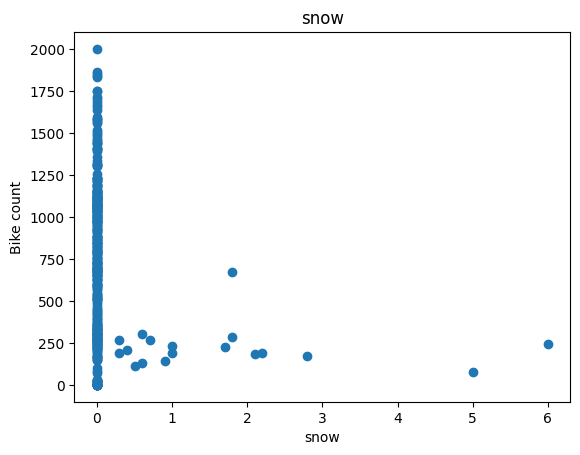

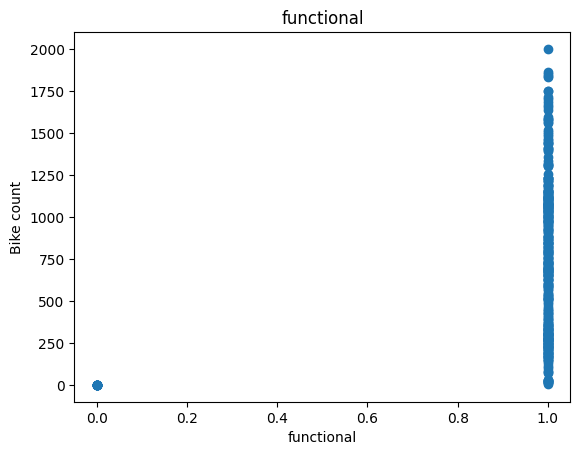

In [4]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.ylabel("Bike count")
  plt.xlabel(label)
  plt.title(label)
  plt.show()

In [5]:
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
13,451,2.4,25,-15.6,1.16,0.0,0.0
37,606,6.0,36,-7.9,1.12,0.0,0.0
61,495,6.8,81,3.7,0.60,0.0,0.0
85,391,0.0,30,-15.5,1.17,0.0,0.0
109,325,-1.6,27,-18.2,0.00,0.0,0.0


#Train, Test and Validation datasets

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  y = dataframe[y_label].values.reshape(-1, 1)

  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

  data = np.hstack((x, y))
  return data, x, y

In [8]:
# linear regression for temperature
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [9]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)
print(temp_reg.coef_, temp_reg.intercept_)

[[22.20742259]] [371.87002091]


In [10]:
temp_reg.score(x_test_temp, y_test_temp) # R squared

0.28381247018601485

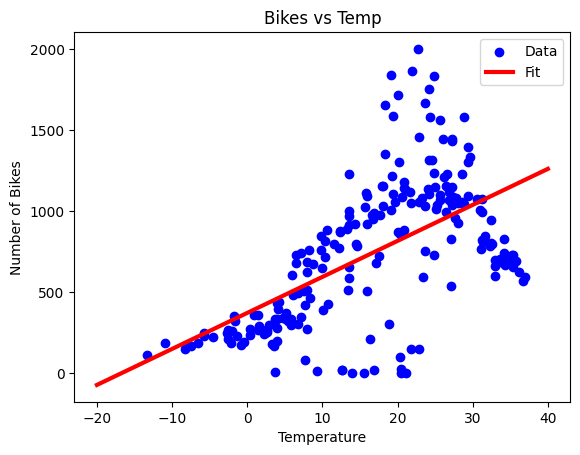

In [11]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

#Multiple Linear Regression

In [12]:
# linear regression for all labels
_, x_train, y_train = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, x_val, y_val = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, x_test, y_test = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [13]:
all_reg = LinearRegression()
all_reg.fit(x_train, y_train)

LinearRegression()

In [14]:
all_reg.score(x_test, y_test) # R squared

0.36387615670919804

#Regression with Neural Net

In [15]:
# Neural Net Regression for temperature
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [17]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [19]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

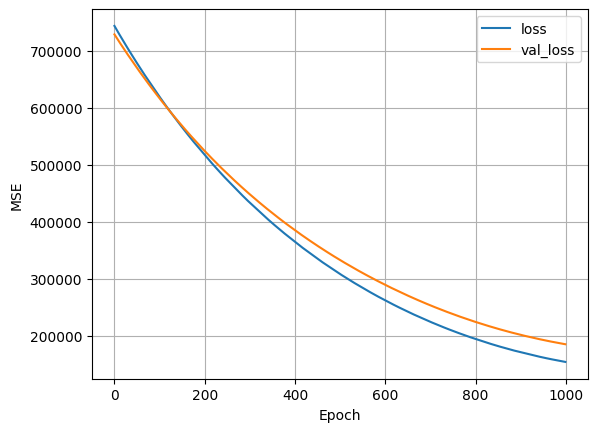

In [20]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


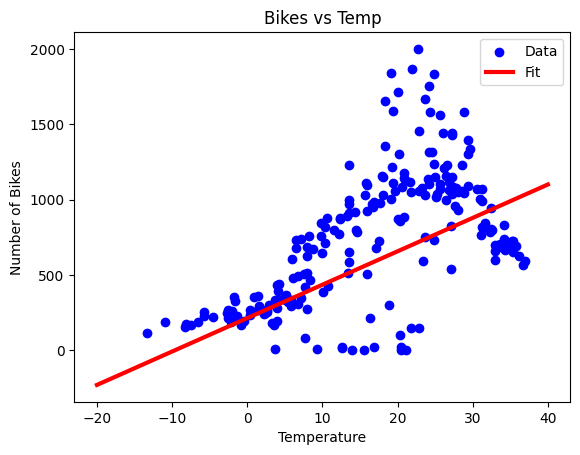

In [21]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

#Neural Network

In [22]:
# For temperature
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

In [23]:
nn_history = nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=100,
    validation_data=(x_val_temp, y_val_temp)
)

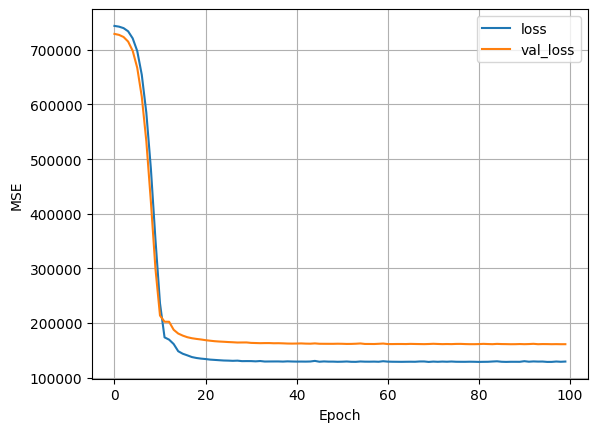

In [24]:
plot_loss(nn_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


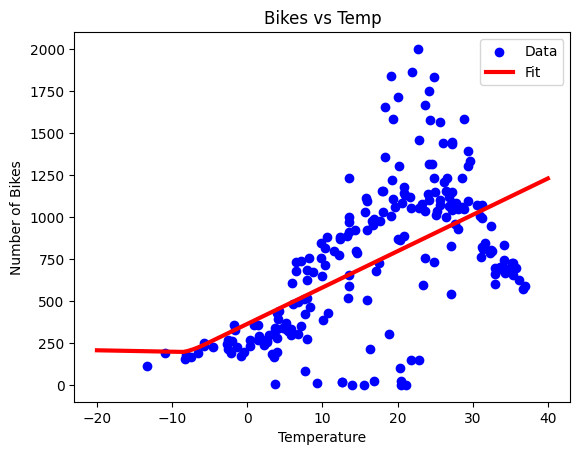

In [25]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

In [26]:
# For all features
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train)

In [27]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [28]:
all_nn_history = all_nn_model.fit(
    x_train, y_train,
    verbose=0,
    epochs=100,
    validation_data=(x_val, y_val)
)

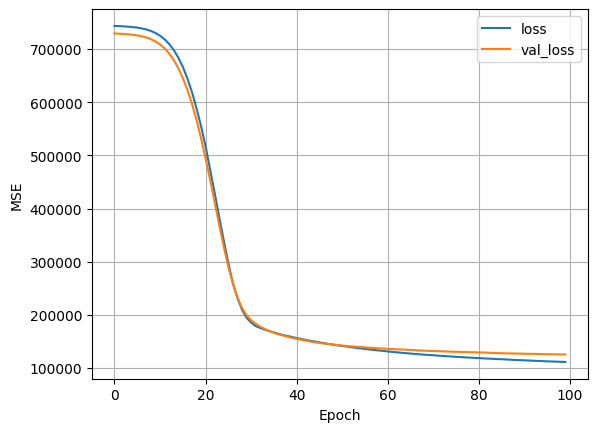

In [29]:
plot_loss(all_nn_history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


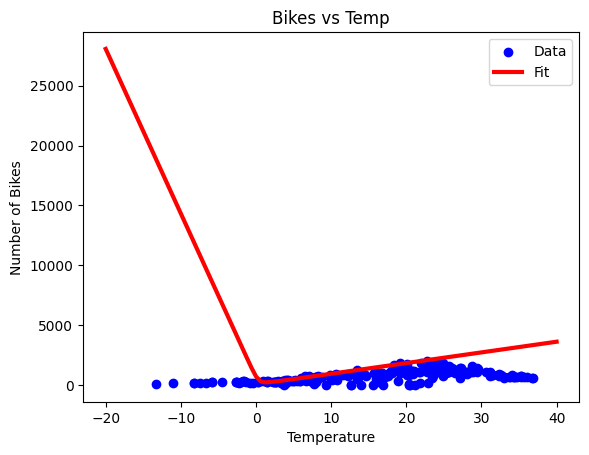

In [30]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, all_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

In [31]:
y_pred_lr = all_reg.predict(x_test)
y_pred_nn = all_nn_model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [32]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [33]:
MSE(y_pred_lr, y_test)

np.float64(146432.88824624644)

In [34]:
MSE(y_pred_nn, y_test)

np.float64(152993.76783173005)

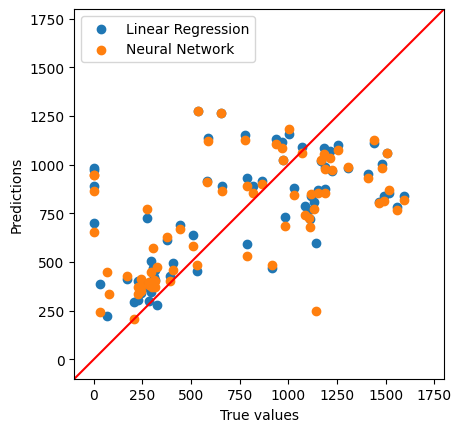

In [38]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_lr, label='Linear Regression')
plt.scatter(y_test, y_pred_nn, label='Neural Network')
plt.ylabel('Predictions')
plt.xlabel('True values')
lims = [-100, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')